In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/hpc-rosneft/drigo/surrogate/src/')
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse

from dataset import load_variable_years
from main import Main
from netcdftools import MyNetCDF

In [8]:
def plotting(pred, y_test,model_data, years_test,title=None):
    # plotting settings
    import matplotlib as mpl
    mpl.rcParams['figure.dpi']= 1200
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [15, 7]
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
    
    plt.plot(pred, label='Predictions')
    plt.plot(y_test, label='Measurements')
    plt.plot(model_data, label = 'NEMO')
    plt.axhline(y=0, color='grey', linestyle='-')
    plt.xlabel('Days since 1 Jan {}'.format(years_test[0]))
    plt.ylabel('Sea ice thickness (m)')
    plt.legend()
    if title is not None: plt.title(title)
    plt.show()
    return plt


def regress(coords, parameters, reg_params):
    point = list(ncdf.coords_to_index(coords)[0].data)
    model_data = load_variable_years('icethic_cea', parameters['years_test'], point)
    y_test = load_variable_years(parameters['y_var'], parameters['years_test'], point)
    
    m=Main(parameters=parameters, reg_params=reg_params)
    pred = m.predict_point(point)
    plotting(pred, y_test, model_data, parameters['years_test'], title = '{}N {}E'.format(coords[0], coords[1]))
    
    rmse_val_pred = rmse(pred, y_test)
    rmse_val_mod = rmse(model_data, y_test)
    results_df.loc[len(results_df)+1] = [coords,
                                     reg_params['dx'],
                                     reg_params['dy'],
                                     reg_params['dt'],
                                     rmse_val_pred,
                                     rmse_val_mod]

Bilding regression with different parameters for 4 points in Arctic ocean:

|Number   | Coordinates  |  Geographical object |
|---|---|---|
|  1 | [78,84]  |  Kara sea |
|  2 | 80,-5  | Fram strait  |
|  3 |  73.6,162 | East Siberian Sea  |
|  4 | 85,-180  |  Open ocean |

<img src="data/map_points.png" alt="map" style="width: 500px;"/>

In [3]:
results_df = pd.DataFrame(columns = ['Point','dx','dy','dt', 'RMSE_surrogate','RMSE_model'])
ncdf = MyNetCDF(path='data/land-exapmle-int.nc')

model = Lasso(alpha=0.1, max_iter=10000)

def rmse(pred, test):
    rmse = np.sqrt(np.nanmean((test - pred)**2))
    #todo - дописать как в статье
    
    return rmse
points = [[78,84],[80,-5],[73.6,162],[85,-180]]

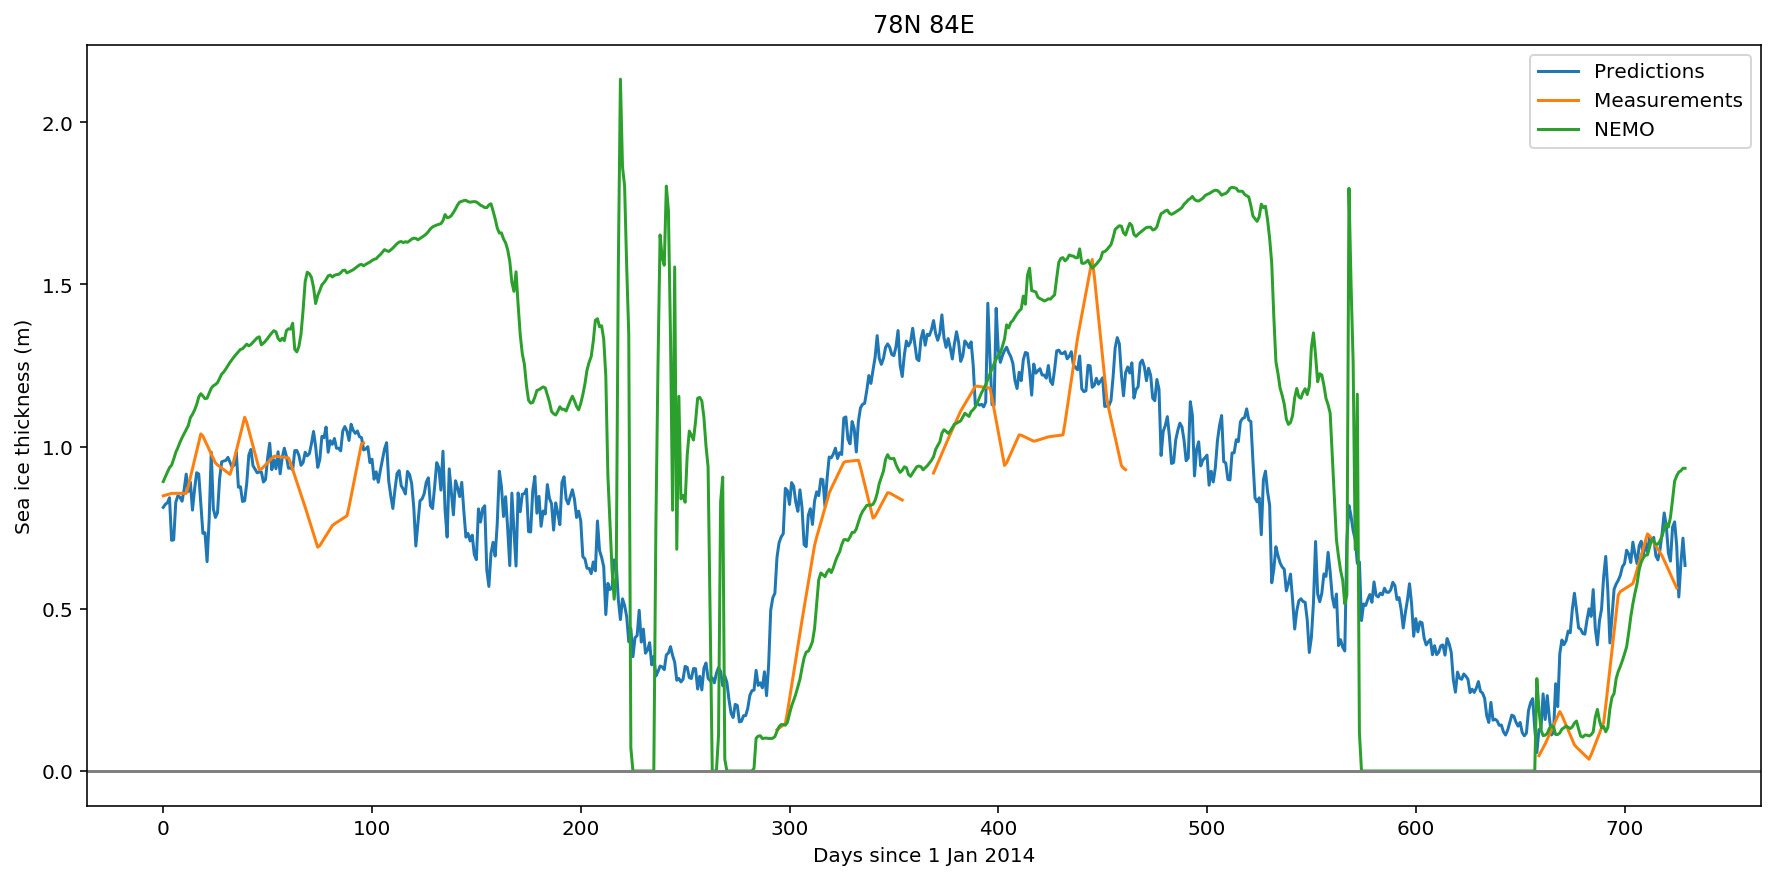

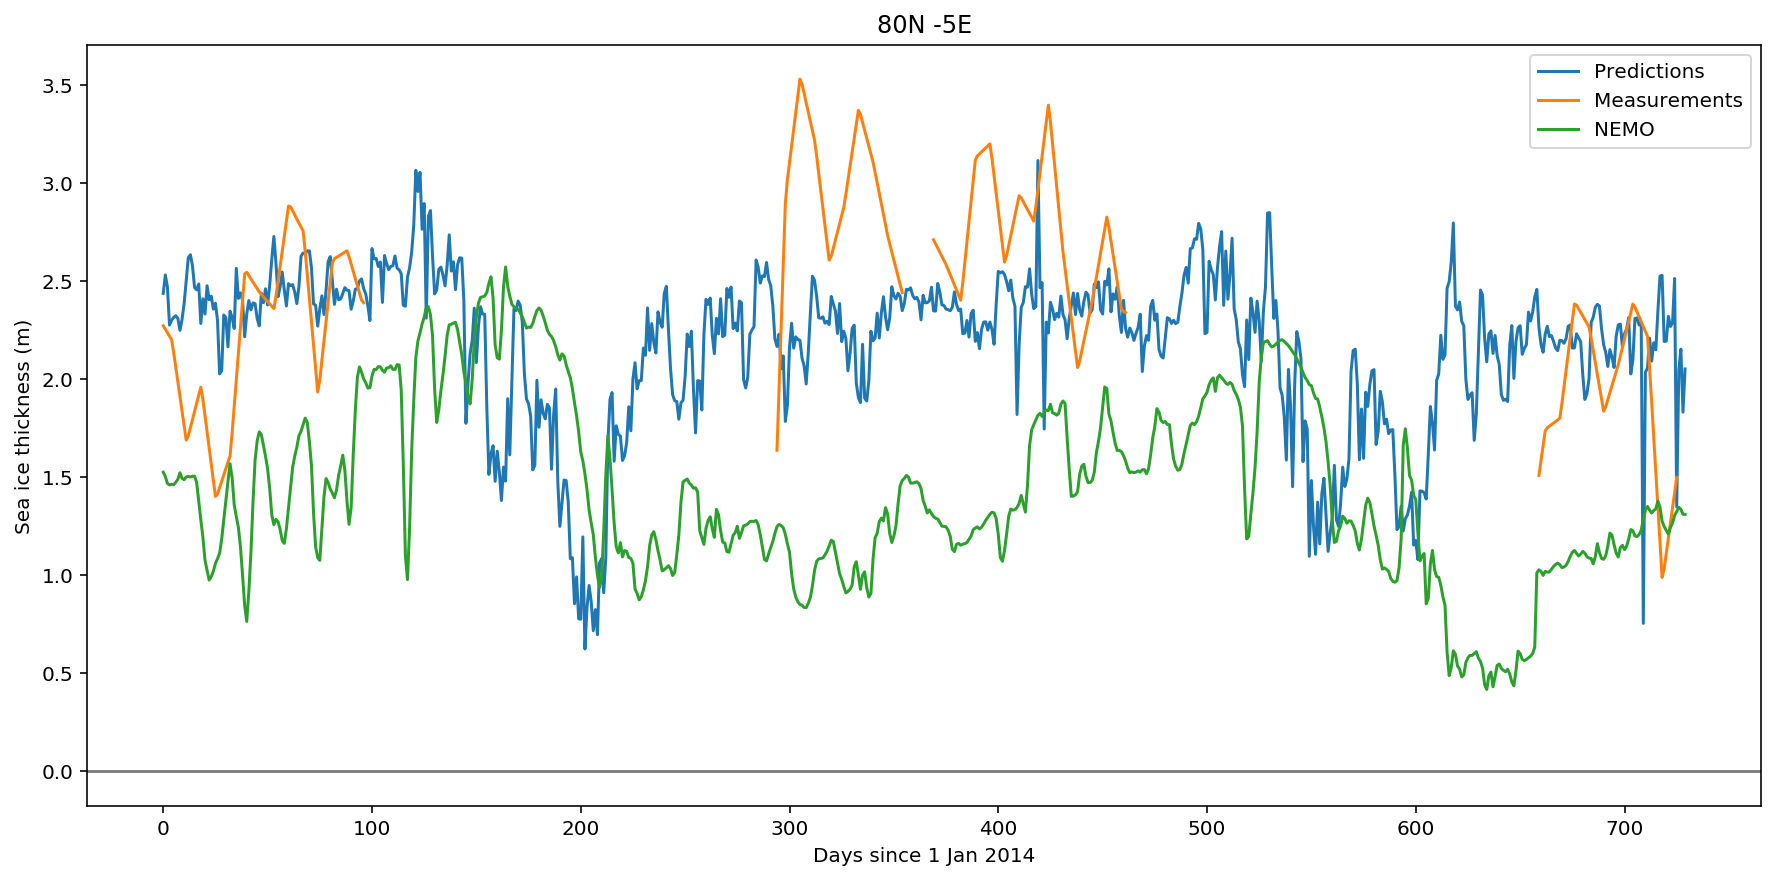

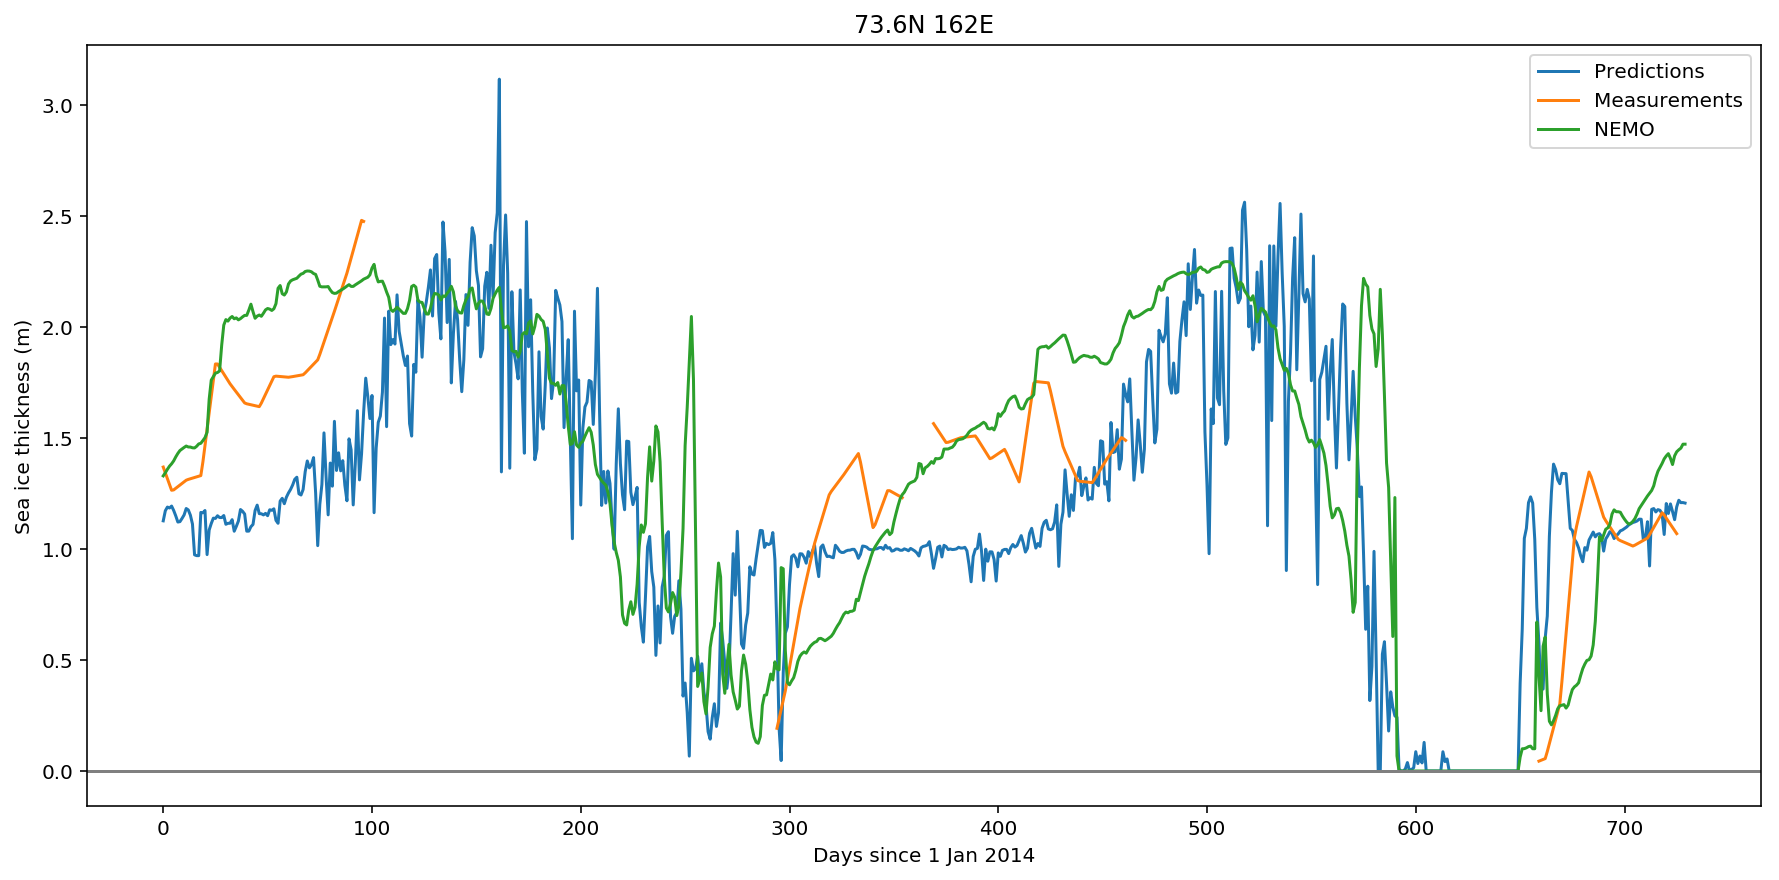

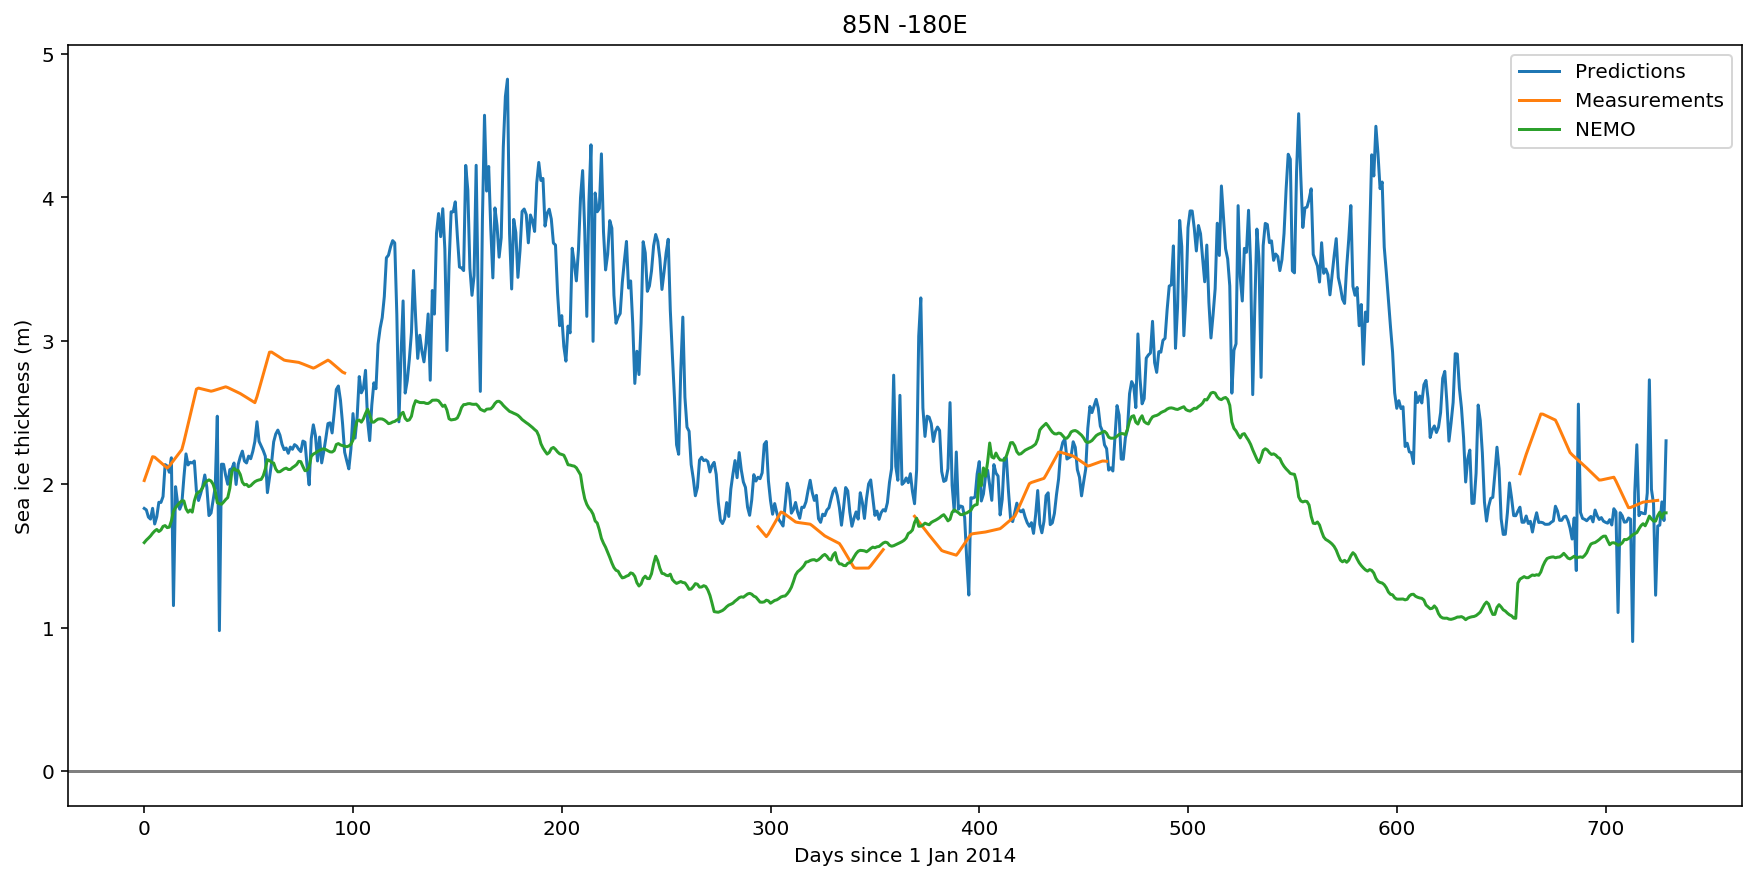

In [4]:
parameters = dict(years_train=list(range(2010, 2014)),
                  years_test=[2014, 2015],
                  X_vars=['ice_conc', 'tair', 'votemper','vosaline','radlw','radsw'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.05, max_iter=10000),
                  dx=5,
                  dy=5,
                  dt=0
                  )
for point in points:
    regress(point, parameters, reg_params)

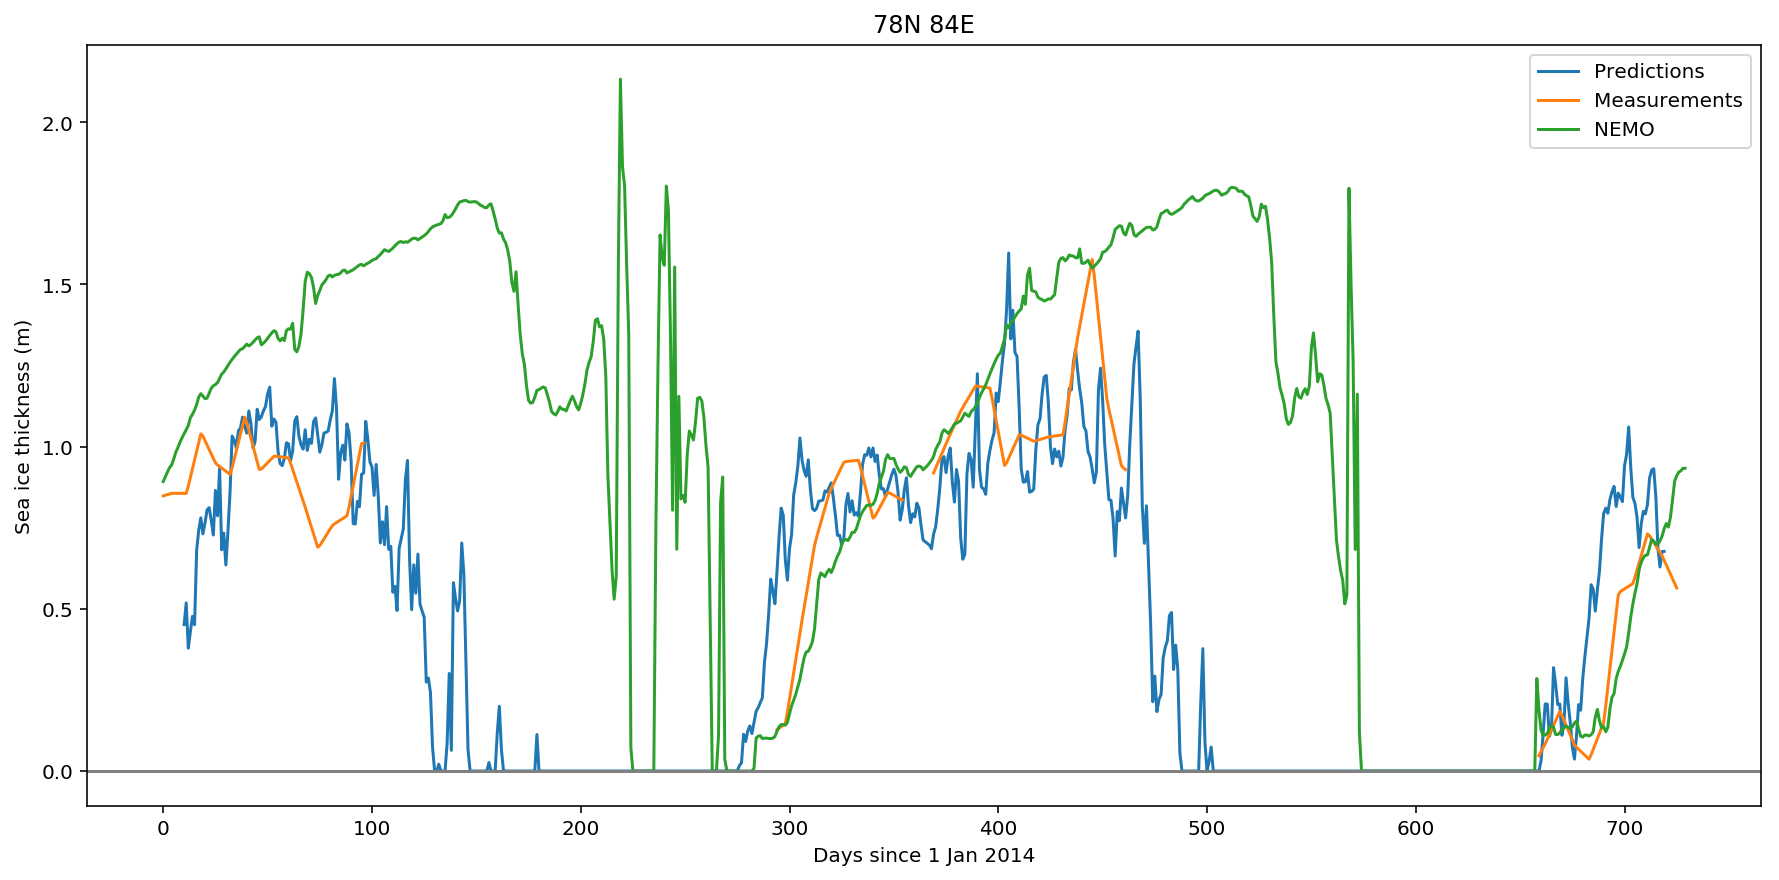

/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


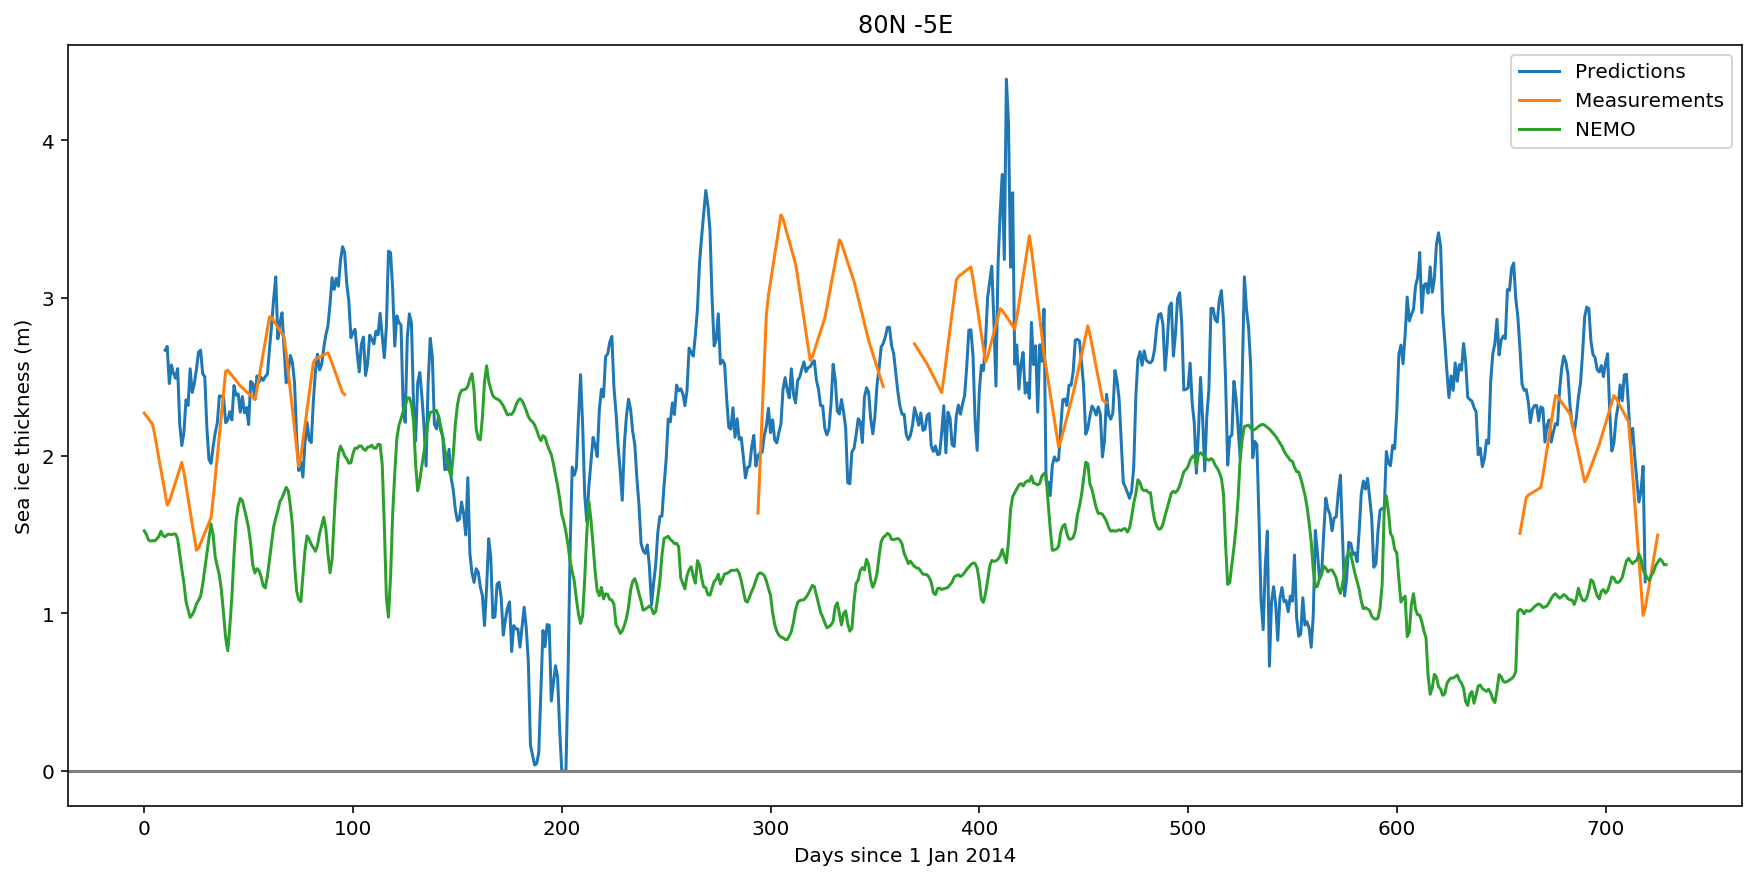

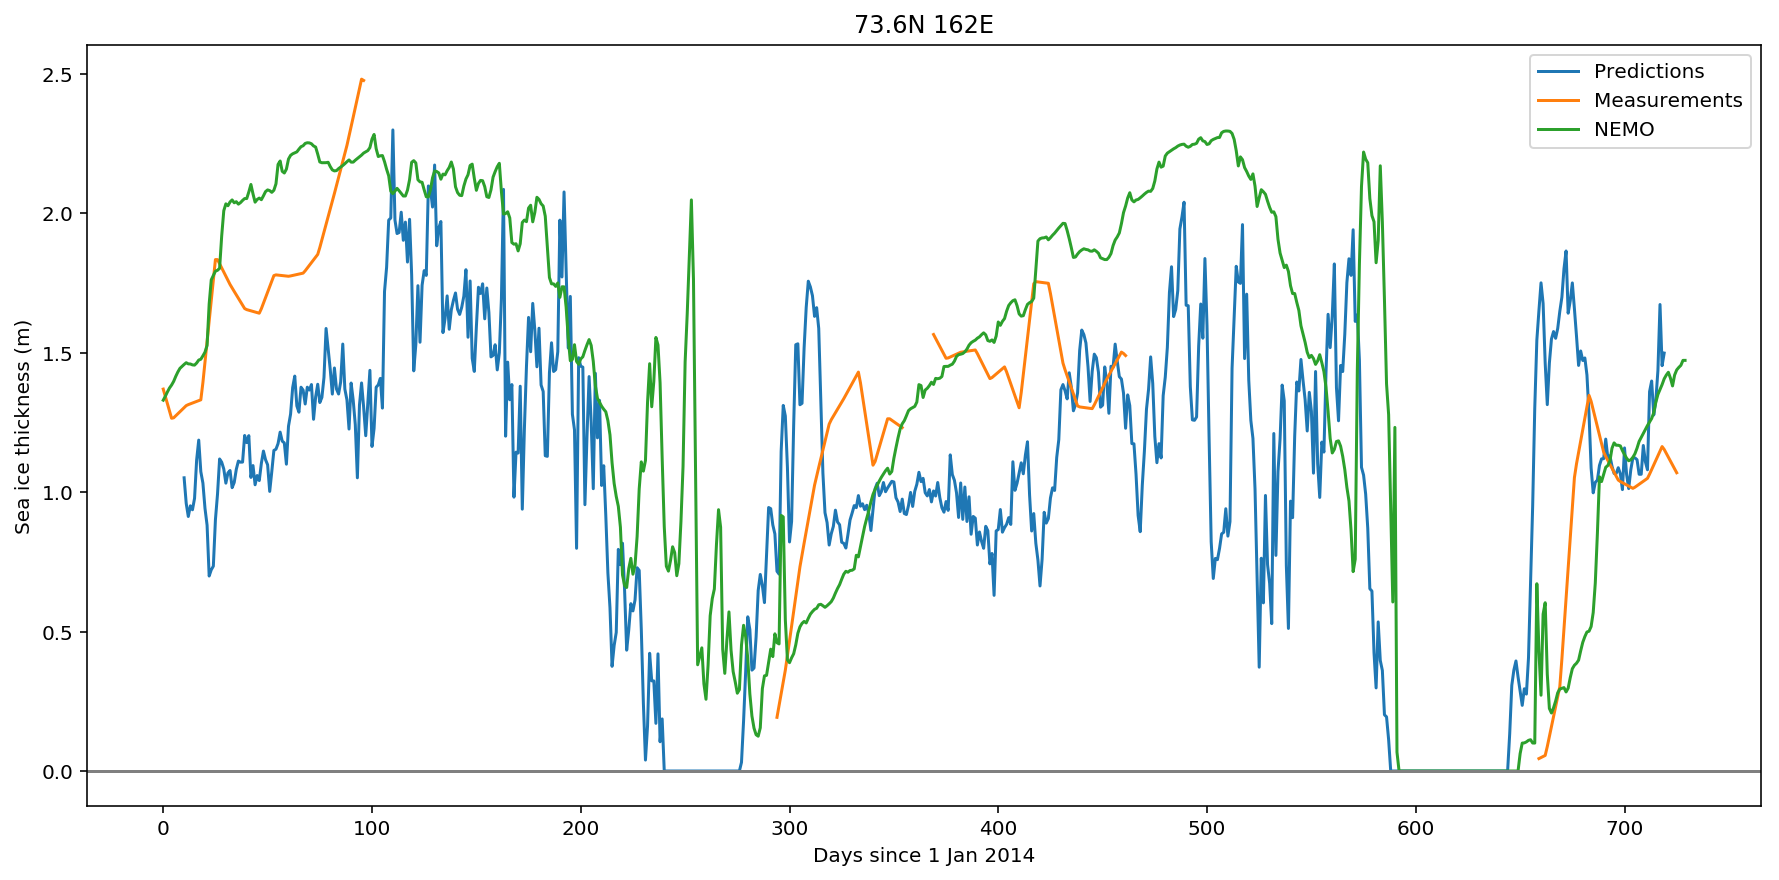

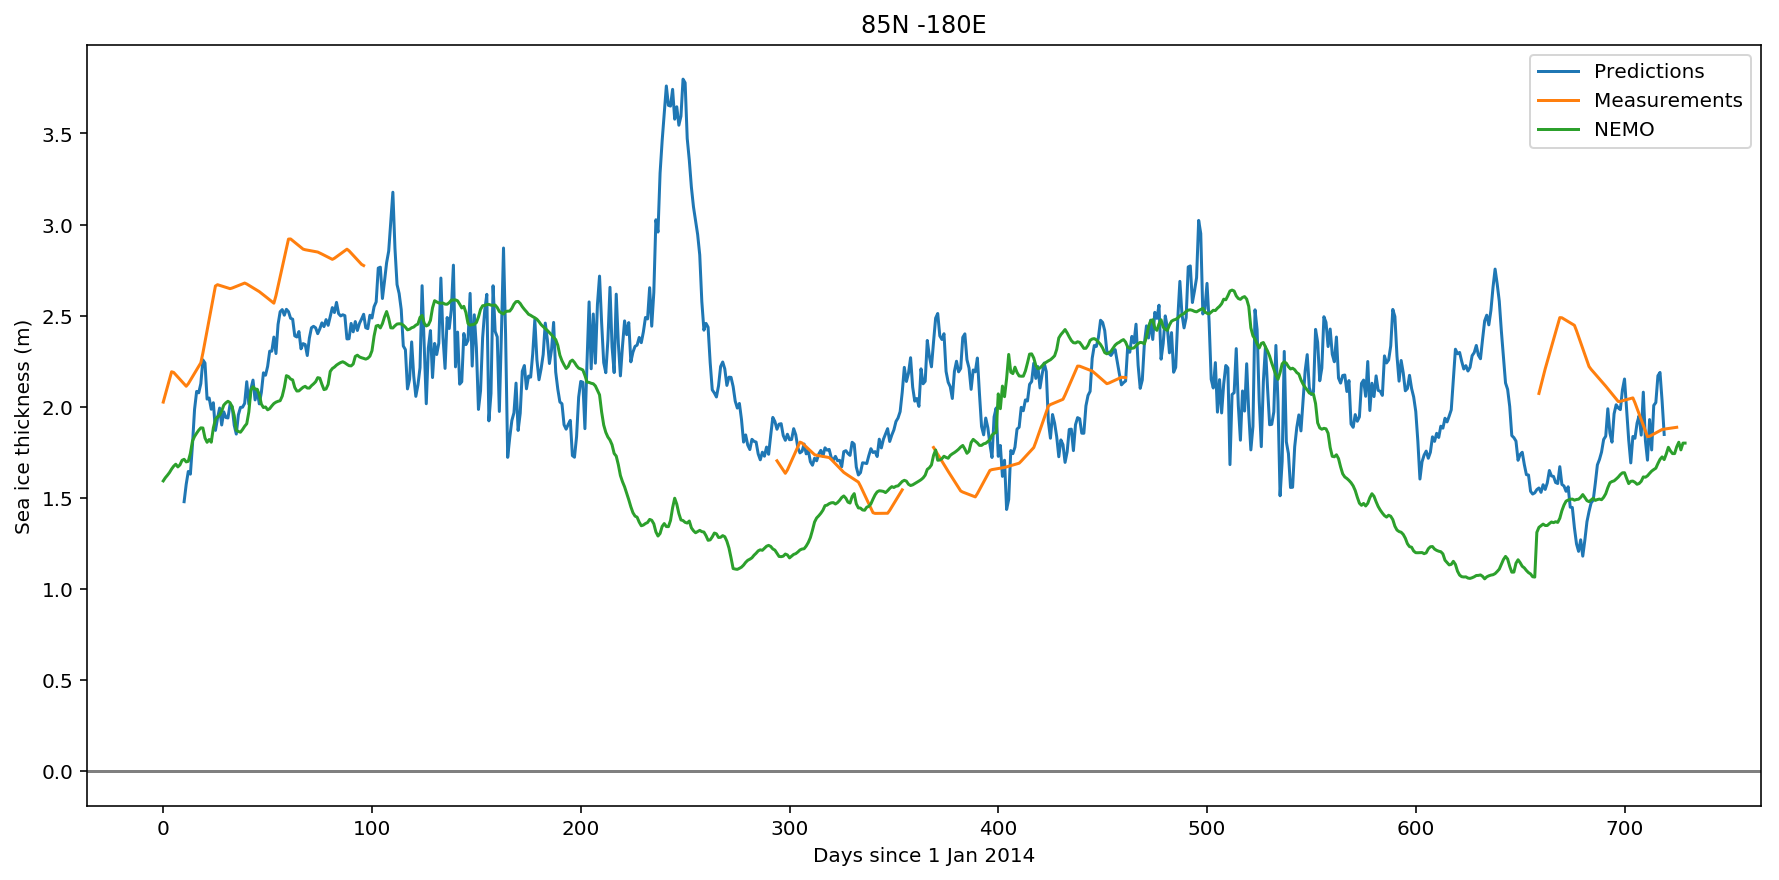

In [5]:
parameters = dict(years_train=list(range(2010, 2014)),
                  years_test=[2014, 2015],
                  X_vars=['ice_conc', 'tair', 'votemper','vosaline','radlw','radsw'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.05, max_iter=10000),
                  dx=10,
                  dy=10,
                  dt=10
                  )
for point in points:
    regress(point, parameters, reg_params)

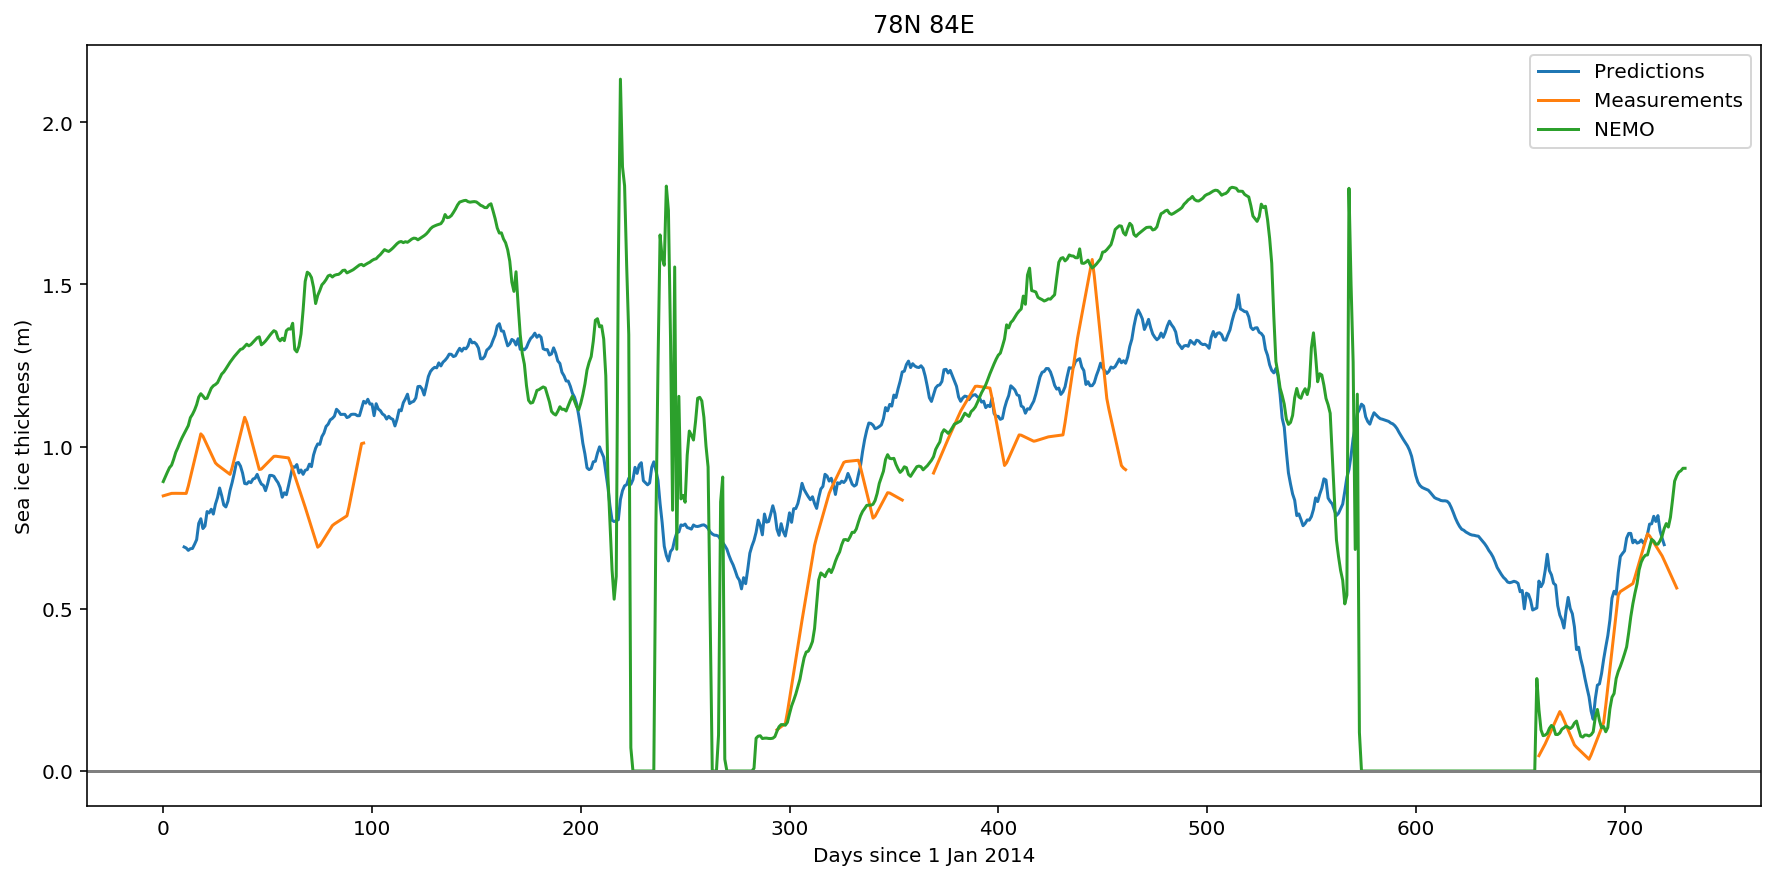

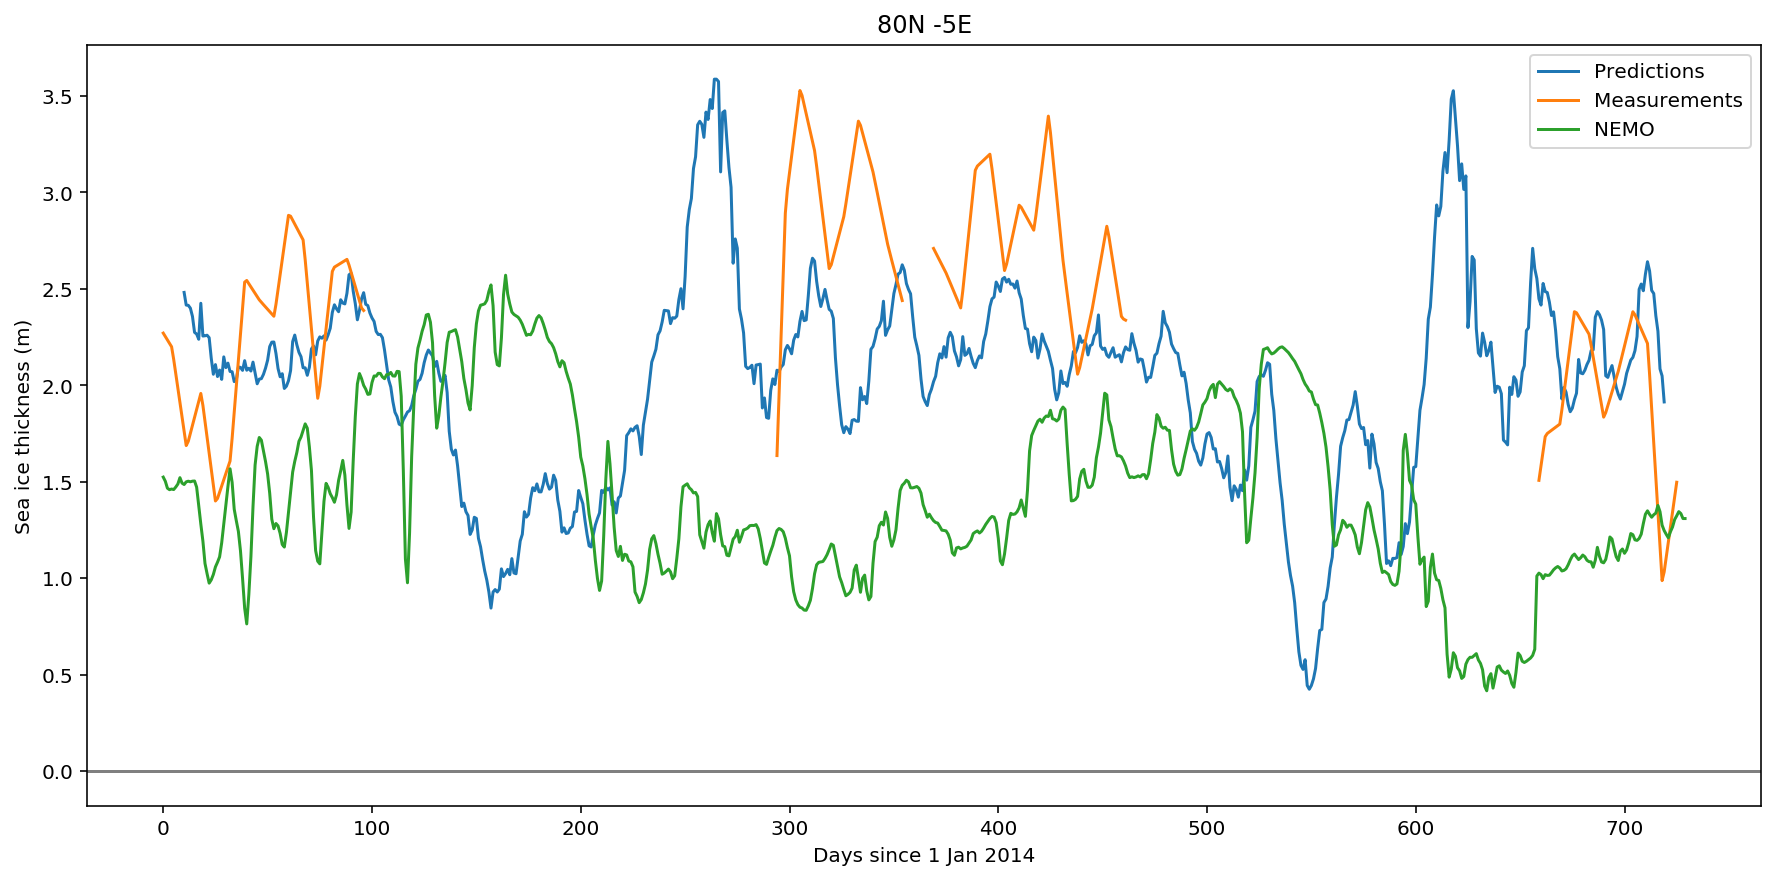

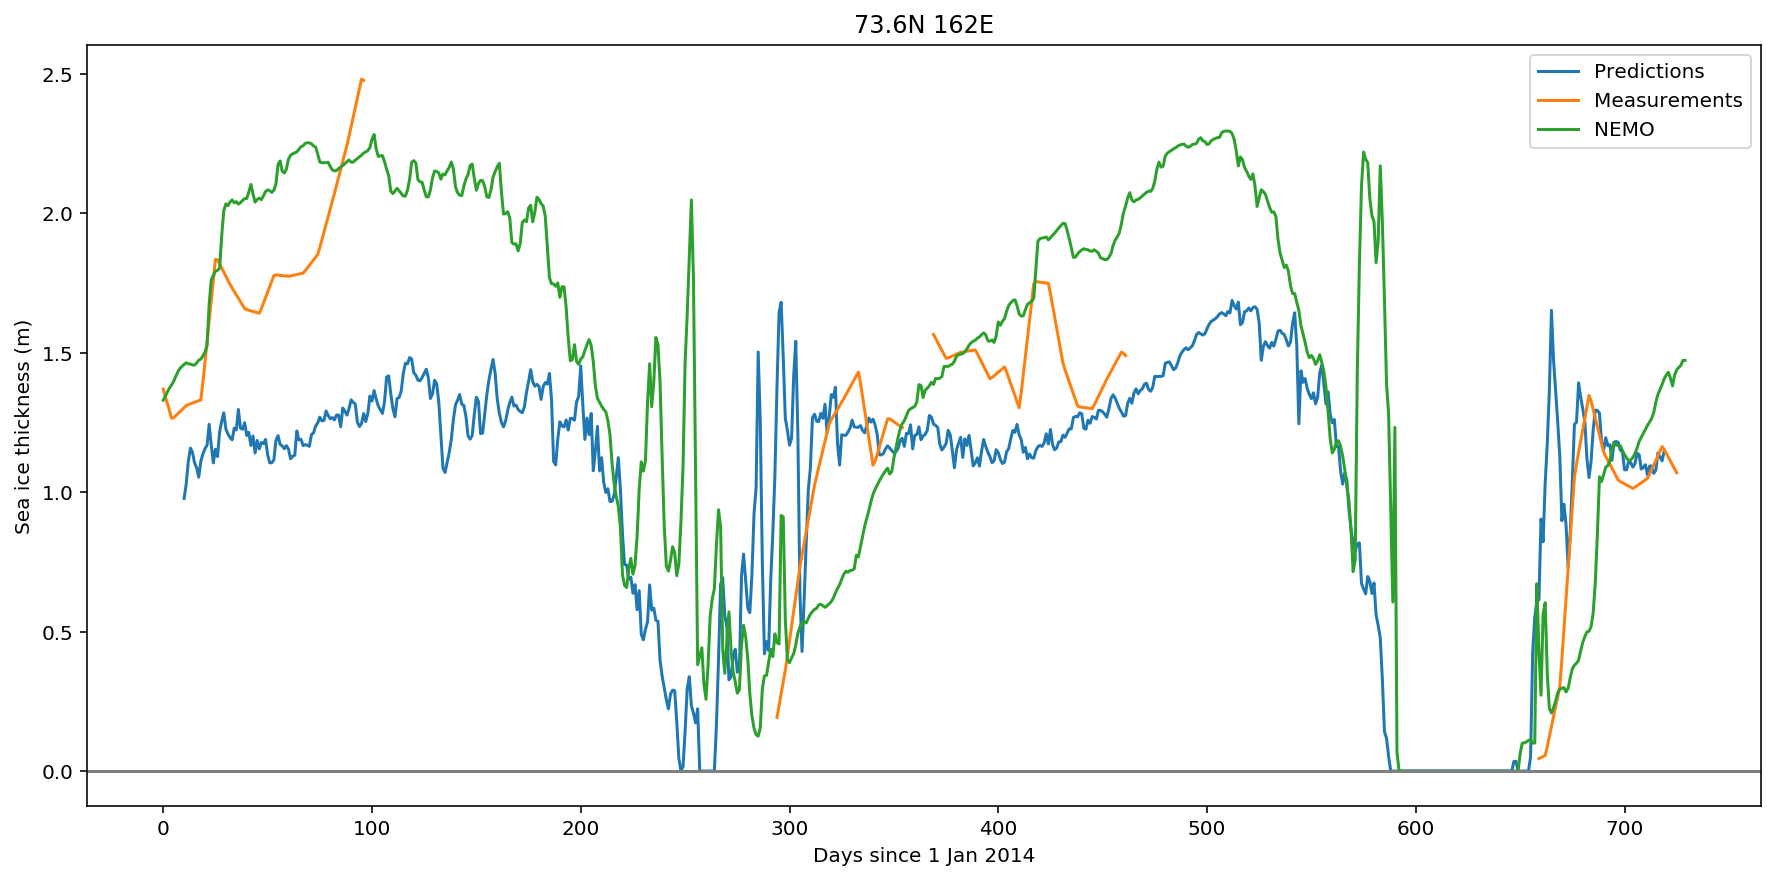

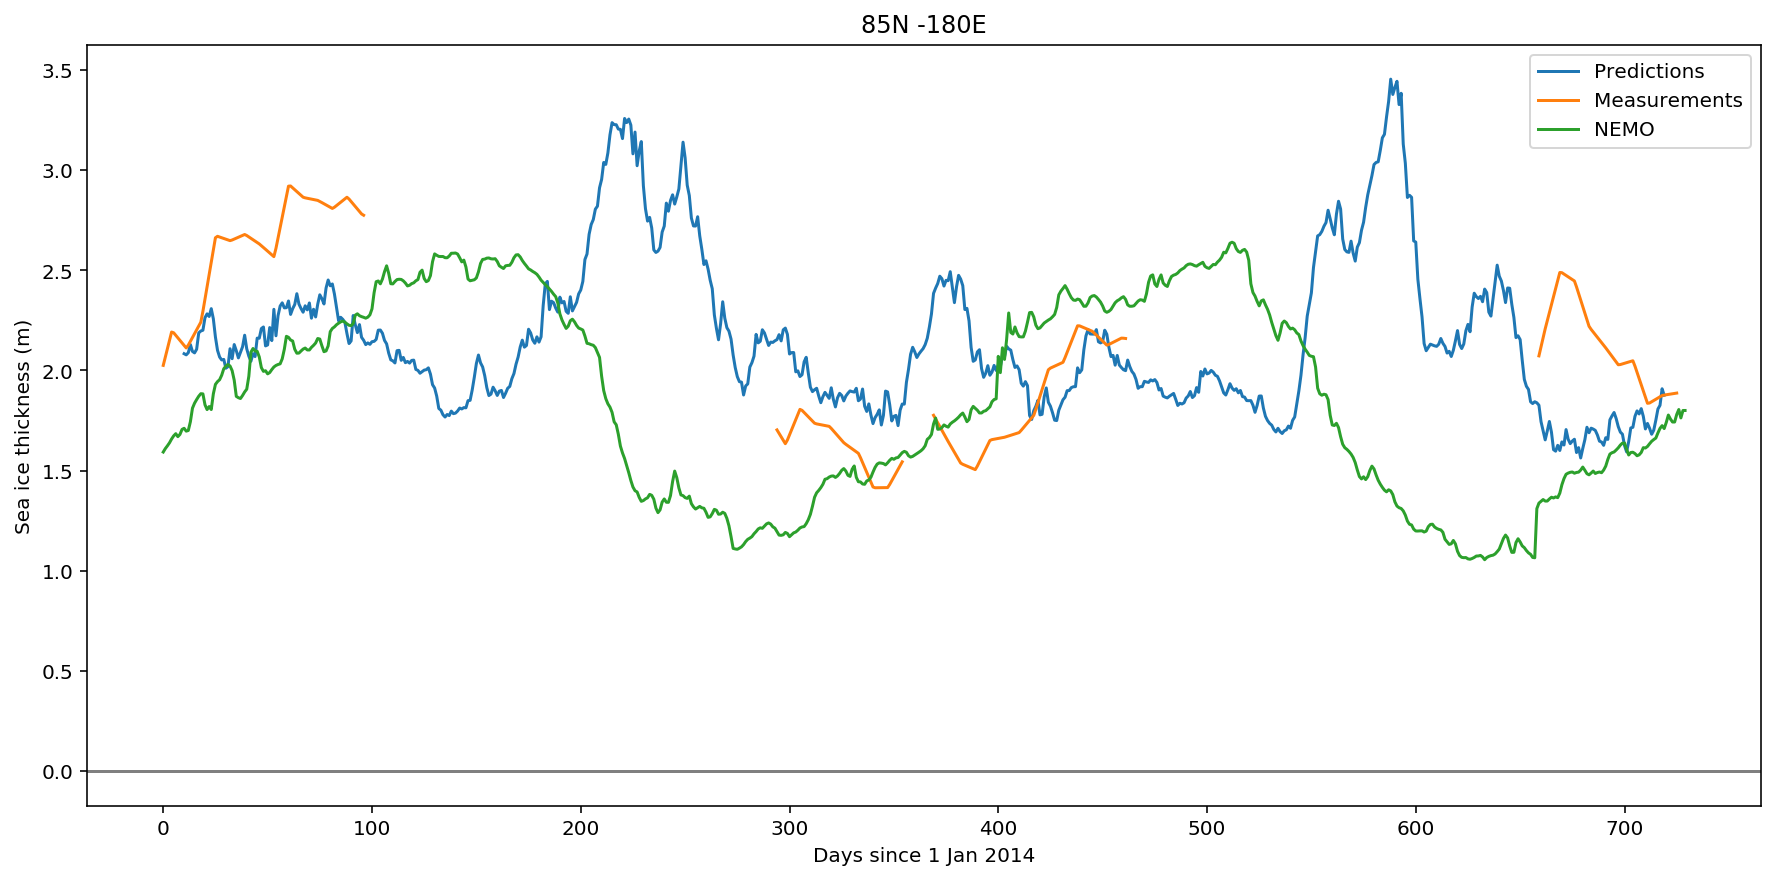

In [6]:
parameters = dict(years_train=list(range(2010, 2014)),
                  years_test=[2014, 2015],
                  X_vars=['ice_conc', 'tair', 'votemper','vosaline'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.05, max_iter=10000),
                  dx=2,
                  dy=2,
                  dt=10
                  )

for point in points:
    regress(point, parameters, reg_params)

In [28]:
results_df.sort_values('Point')

,Point,dx,dy,dt,RMSE_surrogate,RMSE_model
3,"[73.6, 162]",5,5,0,0.455318,0.348049
7,"[73.6, 162]",10,10,10,0.598318,0.348049
11,"[73.6, 162]",2,2,10,0.484404,0.348049
1,"[78, 84]",5,5,0,0.246481,0.334679
5,"[78, 84]",10,10,10,0.262221,0.334679
9,"[78, 84]",2,2,10,0.230217,0.334679
2,"[80, -5]",5,5,0,0.576836,1.278316
6,"[80, -5]",10,10,10,0.568153,1.278316
10,"[80, -5]",2,2,10,0.599789,1.278316
4,"[85, -180]",5,5,0,0.465255,0.505181
